In [1]:
import csv
import time
from pathlib import Path

import numpy as np
import numpy.typing as npt
import pandas as pd
from julia import Main

import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from scipy.integrate import trapezoid

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia
import cma

c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.1+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.1+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
transition_params = (("Q", 1, 1 / 2, 0), ("Q", 1, 1 / 2, 1))
J_fill = [1]

In [4]:
# Parameters
transition_params = [["R", 1, 1.5, 1.0], ["P", 3, 1.5, 1.0]]
J_fill = [1, 3]


In [5]:
trans = []
for t, J, F1, F in transition_params:
    trans.append(
        transitions.OpticalTransition(
            getattr(transitions.OpticalTransitionType, t), J_ground=J, F1=F1, F=F
        )
    )

In [6]:
polarizations = [[couplings.polarization_σm, couplings.polarization_σp]] * len(trans)

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [7]:
Jmax = max([trans.excited_main.largest.J for trans in transition_selectors]) + 2

In [8]:
# ignore small decay to J=6
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    Jmax_X=Jmax,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [9]:
odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0*variable_on_off(t, ton0, toff0, phase0)",
    Ωl0=1 * hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    P0="sin(ω0*t + φ0)",
    Pσm0="P0>0",
    Pσp0="P0<=0",
    ω0=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    Ω1="Ωl1*variable_on_off(t, ton1, toff1, phase1)",
    Ωl1=1 * hamiltonian.Γ,
    δ1=0.0,
    P1="sin(ω1*t + φ1)",
    Pσm1="P1>0",
    Pσp1="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # on/off parameters
    ton0=1e-6,
    toff0=1e-6,
    ton1=1e-6,
    toff1=1e-6,
    phase0=0.0,
    phase1=np.pi,
)

In [10]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [11]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 2, F₁ = 3/2, F = 1>"
states,
"|X, J = 1>",0.709417
"|X, J = 3>",0.290583


In [12]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 2, F₁ = 3/2, F = 1>"
states,
"|X, J = 1, F₁ = 1/2, F = 0>",0.447072
"|X, J = 1, F₁ = 1/2, F = 1>",0.202088
"|X, J = 1, F₁ = 3/2, F = 1>",0.052627
"|X, J = 1, F₁ = 3/2, F = 2>",0.007630
"|X, J = 3, F₁ = 5/2, F = 2>",0.290583


In [13]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J4 = states.QuantumSelector(
    J=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J5 = states.QuantumSelector(
    J=5, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)

In [14]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=J_fill, electronic=states.ElectronicState.X), obe_system.QN
)

In [15]:
odepars.ton0 = 2e-6
odepars.ton1 = 2e-6
odepars.toff0 = 1e-6
odepars.toff1 = 1e-6
odepars.phase0 = 0.0
odepars.phase1 = np.pi
odepars.Ωl0 = hamiltonian.Γ
odepars.Ωl1 = hamiltonian.Γ

In [16]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 260e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [17]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 41.3
rate = 1.59e+05 /s


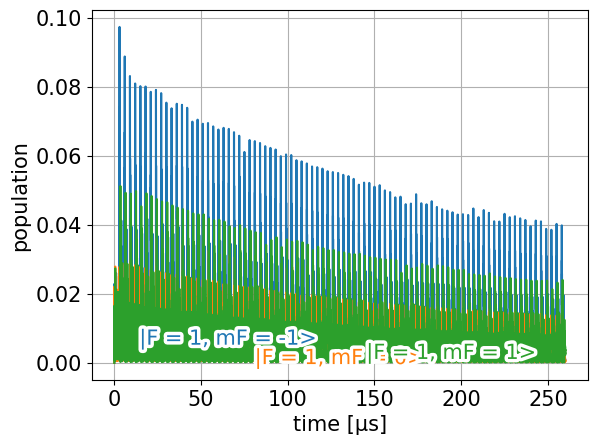

In [18]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"])
    for idx in indices_excited
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} /s")

# photons = 41.3
rate = 1.59e+05 /s


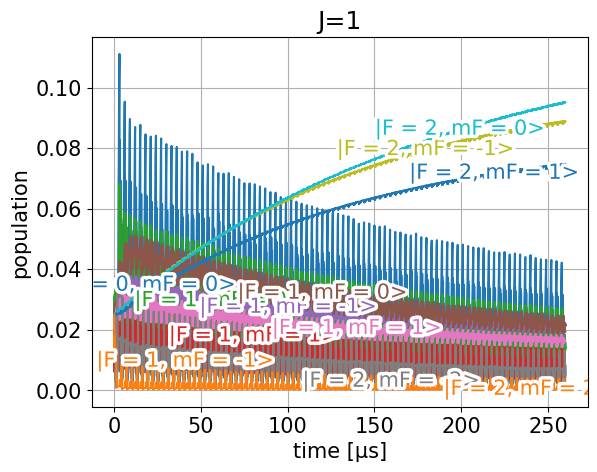

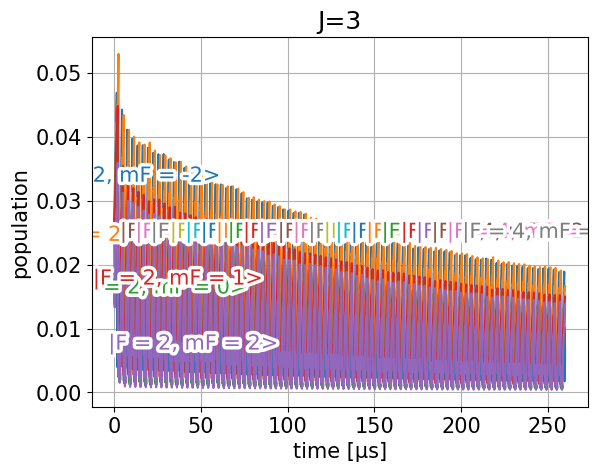

In [19]:
for J, ind in enumerate(
    [indices_J0, indices_J1, indices_J2, indices_J3, indices_J4, indices_J5]
):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} /s")

# CMA-ES

In [20]:
save_idxs_excited = [
    v.item()
    for v in utils.population.get_diagonal_indices_flattened(
        size=len(obe_system.QN), states=indices_excited, mode="julia"
    )
]


In [21]:
def rescale_parameters(parameters: npt.NDArray[np.float64]):
    parameters = np.array(parameters)
    parameters[:, :2] *= hamiltonian.Γ
    parameters[:, 3:5] *= hamiltonian.Γ
    parameters[:, 6:10] /= 1e-6
    return parameters

In [22]:
import copy
from julia import Main

odepars.φ0 = 0.0
odepars.phase0 = 0.0
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6,
    reltol=1e-3,
    abstol=1e-7,
    save_everystep=True,
    callback=None,
    save_idxs=save_idxs_excited,
)
output_function = lindblad_julia.setup_state_integral_calculation_state_idxs(
    nphotons=True, Γ=hamiltonian.Γ
)


def optimize_function(parameters):
    parameter_names = "Ωl0,Ωl1,phase1,ω0,ω1,φ1,ton0,ton1,toff0,toff1".split(",")
    parameters = rescale_parameters(parameters)

    ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
        method="Tsit5()",
        distributed_method="EnsembleDistributed()",
        save_everystep=True,
        save_idxs=save_idxs_excited,
        callback=None,
        reltol=1e-3,
        abstol=1e-7,
        saveat=1e-6,
    )

    ensemble_problem = lindblad_julia.OBEEnsembleProblem(
        problem=problem,
        parameters=parameter_names,
        scan_values=parameters.T,
        output_func=output_function,
        zipped=True,
    )

    lindblad_julia.setup_problem_parameter_scan(
        ensemble_problem,
    )

    lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

    results_scan = lindblad_julia.get_results_parameter_scan(ensemble_problem)

    return results_scan

In [23]:
parameter_names = "Ωl0,Ωl1,phase1,ω0,ω1,φ1,ton0,ton1,toff0,toff1".split(",")

In [24]:
D = 2.6675506e-30
intensity = 2 / (25.4e-3 * 2 * 25.4e-3)  # 2W over 1x2"

rabi0 = (
    utils.rabi.intensity_to_rabi(
        intensity, np.abs(obe_system.couplings[0].main_coupling), D
    )
    / hamiltonian.Γ
)
rabi1 = (
    utils.rabi.intensity_to_rabi(
        intensity, np.abs(obe_system.couplings[1].main_coupling.real), D
    )
    / hamiltonian.Γ
)

In [25]:
initial_parameters = [rabi0 / 2, rabi1 / 2] + [np.pi, 1, 1, np.pi, 2, 1, 2, 1]
sigma = 2.0
stds = [rabi0 / 2, rabi0 / 2] + [2] * 8
es = cma.CMAEvolutionStrategy(
    initial_parameters,
    sigma,
    {
        "bounds": [
            [0],
            [
                rabi0,
                rabi1,
                2 * np.pi,
                2,
                2,
                2 * np.pi,
                40,
                40,
            ],
        ],
        "popsize": 25,
        "CMA_stds": stds,
    },
)

(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 10 (seed=411678, Wed Oct 30 11:14:55 2024)


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\cma\evolution_strategy.py:1244: UserWarning: Sampling standard deviation i=0 at iteration 0 change by 0.3333333333333333 to stds[0]=0.02567802392593508
  warnings.warn("Sampling standard deviation i={0} at iteration {1}"
c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\cma\evolution_strategy.py:1244: UserWarning: Sampling standard deviation i=2 at iteration 0 change by 0.5235935396367227 to stds[2]=2.0943951023931953
  warnings.warn("Sampling standard deviation i={0} at iteration {1}"
c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\cma\evolution_strategy.py:1244: UserWarning: Sampling standard deviation i=3 at iteration 0 change by 0.16666416668541656 to stds[3]=0.6666666666666666
  warnings.warn("Sampling standard deviation i={0} at iteration {1}"
c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\cma\evolution_strategy.py:1244: UserWarning: Sampling standard deviation i

In [26]:
niterations = 200
tstart = time.time()
old_max = 0.0
global_max = 0.0
data = np.zeros([niterations * es.popsize, len(parameter_names) + 1])
for count in range(niterations):
    X = es.ask()
    res = optimize_function(X)
    es.tell(X, -res.results)
    es.logger.add()
    es.disp()

    data[count * es.popsize : (count + 1) * es.popsize, : len(parameter_names)] = (
        np.array(X)
    )
    data[count * es.popsize : (count + 1) * es.popsize, -1] = res.results

    # stop conditions
    if count > 3:
        new_max = data[count * es.popsize : (count + 1) * es.popsize, -1].max()
        if (
            abs((new_max - global_max) / new_max) < 5e-3
            and abs((new_max - old_max) / new_max) < 1e-2
            and np.sum((es.mean - es.mean_old) ** 2) < 2e-2
        ):
            print("stop optimization 1")
            break
        elif (
            (count > 4)
            and np.ptp(
                data[(count - 4) * es.popsize : (count + 1) * es.popsize, -1]
                .reshape(-1, es.popsize)
                .max(axis=1)
            )
            < 3e-1
        ) and (
            np.ptp(data[(count - 4) * es.popsize : (count + 1) * es.popsize, -1])
            / data[(count - 4) * es.popsize : (count + 1) * es.popsize, -1].max()
        ) < 0.15:
            print("stop optimizaton from ptp")
            break
        elif time.time() - tstart > 3600:
            break
        if new_max > global_max:
            global_max = new_max
        old_max = new_max

data = data[: np.nonzero(data[:, -1])[0][-1] + 1]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


    1     25 -1.010902461112721e+01 1.0e+00 2.04e+00  3e-02  4e+00 0:16.5


    2     50 -1.210367298235470e+01 1.3e+00 2.36e+00  3e-02  5e+00 0:18.9


    3     75 -1.217527735567985e+01 1.5e+00 2.72e+00  3e-02  6e+00 0:21.2


    5    125 -1.222526728077978e+01 1.9e+00 3.53e+00  3e-02  8e+00 0:25.1


    7    175 -1.165480153801643e+01 2.1e+00 4.20e+00  3e-02  1e+01 0:30.1


    9    225 -1.198448521981911e+01 2.3e+00 3.69e+00  2e-02  9e+00 0:35.7


   12    300 -1.241667963364450e+01 2.5e+00 2.94e+00  1e-02  7e+00 0:43.6


   15    375 -1.231078904292169e+01 3.2e+00 2.70e+00  1e-02  7e+00 0:52.0


   19    475 -1.243716950262963e+01 4.5e+00 2.58e+00  9e-03  7e+00 1:02.0


   23    575 -1.256421629310241e+01 6.2e+00 2.34e+00  7e-03  6e+00 1:12.7


   27    675 -1.252743517314162e+01 7.7e+00 2.16e+00  5e-03  5e+00 1:22.9


   32    800 -1.256588774321318e+01 9.2e+00 2.52e+00  5e-03  7e+00 1:35.6


stop optimizaton from ptp


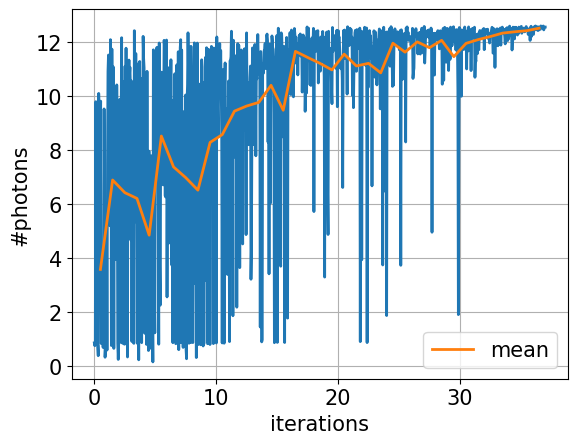

In [27]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, len(data) // es.popsize, len(data)), data[:, -1], lw=2)
ax.plot(
    np.arange(len(data) // es.popsize) + 1 / 2,
    data[:, -1].reshape(-1, es.popsize).mean(axis=1),
    lw=2,
    label="mean",
)

ax.set_xlabel("iterations")
ax.set_ylabel("#photons")
ax.legend()
ax.grid()

In [28]:
def search_figure(param1: str, param2: str, parameter_names: list[str]):
    idx1, idx2 = parameter_names.index(param1), parameter_names.index(param2)
    fig, ax = plt.subplots()
    ax.scatter(*data[:, [idx1, idx2]].T, c=np.arange(len(data)), s=10)

    ax.set_xlabel(param1)
    ax.set_ylabel(param2)
    return fig, ax


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='toff0', ylabel='toff1'>)

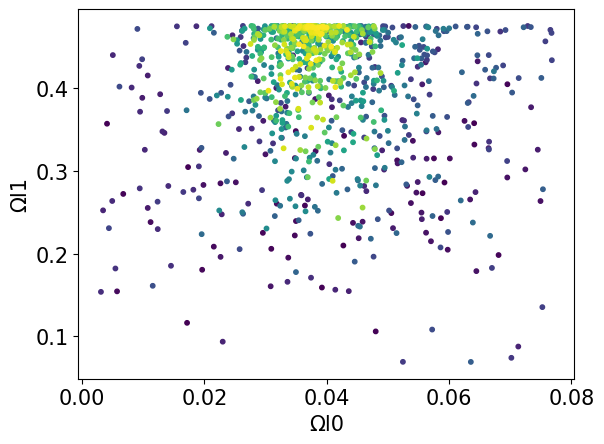

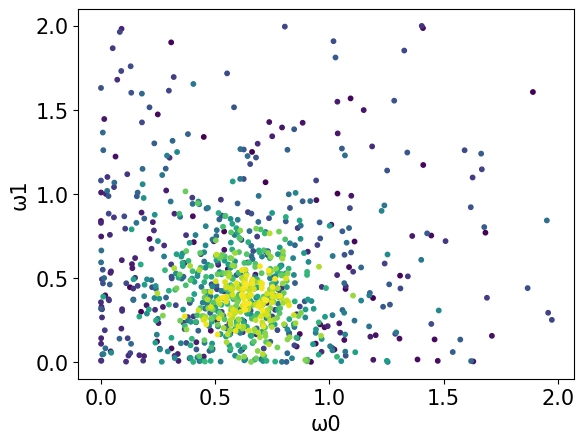

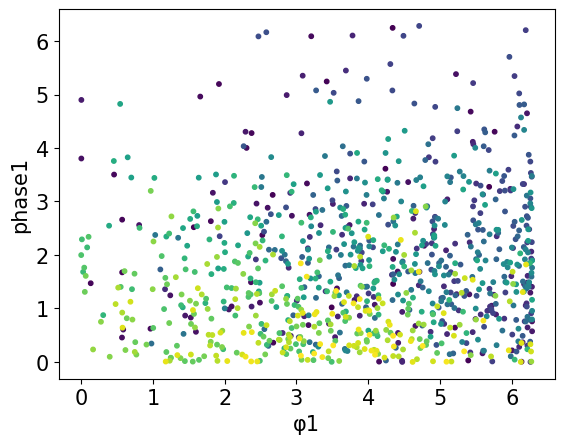

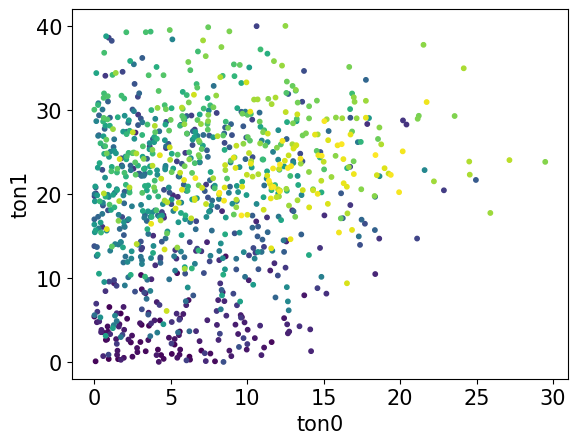

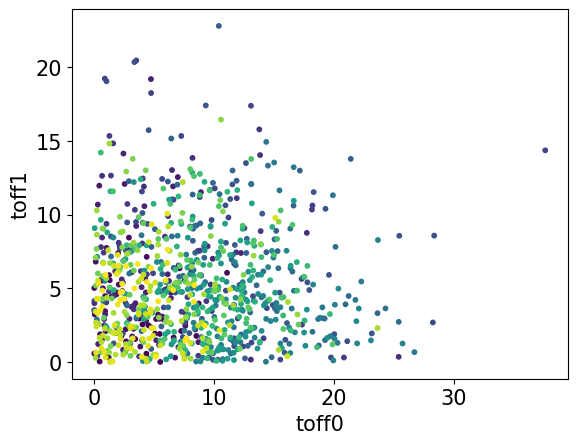

In [29]:
search_figure("Ωl0", "Ωl1", parameter_names)
search_figure("ω0", "ω1", parameter_names)
search_figure("φ1", "phase1", parameter_names)
search_figure("ton0", "ton1", parameter_names)
search_figure("toff0", "toff1", parameter_names)

In [30]:
df = pd.DataFrame(
    dict([(param, dat) for param, dat in zip(parameter_names + ["nphotons"], data.T)])
)
df

,Ωl0,Ωl1,phase1,ω0,ω1,φ1,ton0,ton1,toff0,toff1,nphotons
0,0.064091,0.357740,3.274074,1.190628,0.379989,5.684817,1.555092,0.334931,4.513120,2.485940,0.854100
1,0.017160,0.116308,6.246611,0.661304,1.248726,4.339639,1.724749,5.765501,2.259832,1.754666,0.747598
2,0.042710,0.209814,1.457841,0.449924,1.337841,4.346600,0.941110,0.351395,8.079972,6.084506,0.881268
3,0.059241,0.286021,1.019799,0.245077,0.121380,3.490283,3.094255,4.417338,0.547772,5.574028,9.802796
4,0.004075,0.357135,2.518750,0.175685,0.298419,1.568982,0.983762,6.537870,5.454757,1.898422,1.367207
...,...,...,...,...,...,...,...,...,...,...,...
920,0.036828,0.473575,0.488431,0.647652,0.348985,4.345788,12.140850,23.504343,5.114384,0.342424,12.610313
921,0.040720,0.450469,0.116161,0.631319,0.339164,3.061668,18.385722,24.623120,4.748290,6.350432,12.465987
922,0.035470,0.453224,0.505754,0.631338,0.308926,4.018134,8.179667,20.138430,7.676911,1.607374,12.552117
923,0.039361,0.474640,1.327183,0.724716,0.366929,3.552542,11.416900,21.574389,2.331774,4.762752,12.569417


In [31]:
df_path = Path().cwd() / (
    " __ ".join([t.name.replace("'", "").replace("/", "_") for t in trans]) + "_cma.csv"
)
df.to_csv(df_path, sep=",", index=False)


In [32]:
import logging

best_parameters = dict(
    [(param, val) for param, val in zip(parameter_names, es.result.xbest)]
)
best_parameters

csv_path = Path().cwd() / "results_cma.csv"
trans_names = ["transition", "J_ground", "F1", "F"]

row = dict(
    [
        (name + f" {idx}", t)
        for idx, trans in enumerate(transition_params)
        for name, t in zip(trans_names, trans)
    ]
)
row.update(best_parameters)
row["photons"] = abs(es.result.fbest.item())
file_exists = csv_path.exists()

try:
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(row.keys()), delimiter=",")
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)
except Exception as e:
    logging.error(e)

# Simulate the best parameters

In [33]:
odepars_opt = copy.copy(odepars)
for key, value in zip(
    parameter_names, rescale_parameters(es.result.xbest[np.newaxis, :]).flatten()
):
    setattr(odepars_opt, key, value)

In [34]:
# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars_opt, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6,
    reltol=1e-3,
    abstol=1e-7,
    save_everystep=True,
    callback=None,
    save_idxs=save_idxs,
)
lindblad_julia.setup_problem(problem.odepars, problem.tspan, problem.ρ, problem.name)

In [35]:
lindblad_julia.solve_problem(problem, config)
results = lindblad_julia.OBEResult(
    t=np.array(Main.eval("sol.t")), y=np.array(Main.eval("sol.u[:]")).real.T
)

# photons = 12.6
rate = 6.31e+04 1/s


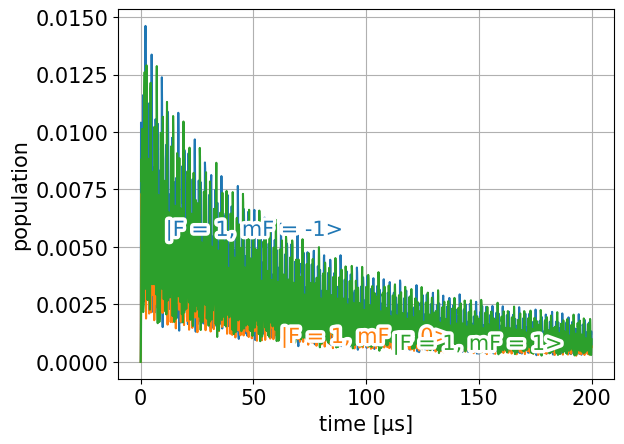

In [36]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"])
    for idx in indices_excited
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} 1/s")

# photons = 12.6
rate = 6.31e+04 1/s


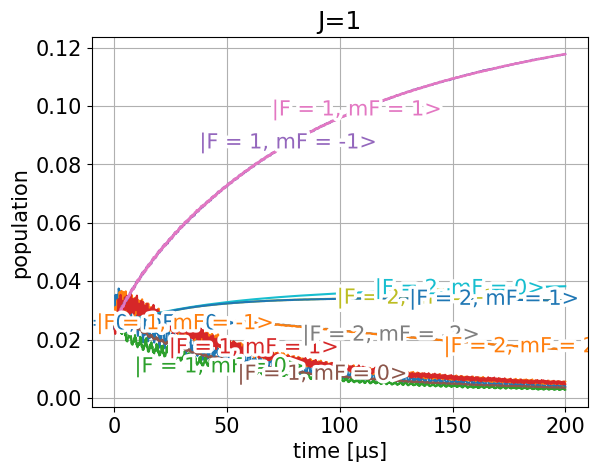

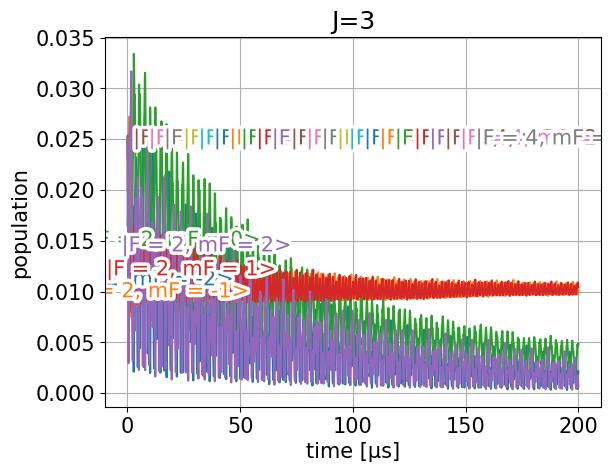

In [37]:
for J, ind in enumerate(
    [indices_J0, indices_J1, indices_J2, indices_J3, indices_J4, indices_J5]
):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} 1/s")